In [113]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random
import scipy.io as spio

def pass_arg(nsim, tr_size, dropoutrate):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #     K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)

    # MC dropout
    class MCDropout(Dropout):
        def call(self, inputs, training=None):
            return super(MCDropout, self).call(inputs, training=True)

    # import pickle

    # def save_obj(obj, name):
    #     with open(name, 'wb') as f:
    #         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    
    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


    #function for computing the density given the temperature(nx1 matrix)
    def density(temp):
        return 1000 * ( 1 - (temp + 288.9414) * (temp - 3.9863)**2 / (508929.2 * (temp + 68.12963) ) )

    def phy_loss_mean(params):
        # useful for cross-checking training
        udendiff, lam = params
        def loss(y_true,y_pred):
            return K.mean(K.relu(udendiff))
        return loss

    #function to calculate the combined loss = sum of rmse and phy based loss
    def combined_loss(params):
        udendiff, lam = params
        def loss(y_true,y_pred):
            return mean_squared_error(y_true, y_pred) + lam * K.mean(K.relu(udendiff))
        return loss

    def PGNN_train_test(lake_name, optimizer_name, optimizer_val, drop_frac, 
                        use_YPhy, iteration, n_layers, n_nodes, tr_size, lamda, reg):

    #     fix_seeds(ss)

        # Hyper-parameters of the training process
    #     batch_size = tr_size
        batch_size = 1000
        num_epochs = 1000
        val_frac = 0.2
        patience_val = 100

        # Initializing results filename
        exp_name = "DNN_loss" + optimizer_name + '_drop' + str(drop_frac) + '_usePhy' + str(use_YPhy) +  '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_lamda' + str(lamda) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '_model.h5' # storing the trained model

#         if reg==True and samp==25:
#             results_name = results_dir + exp_name + '_results_25_regularizer.dat' # storing the results of the model
#         elif reg==False and samp==25:
#             results_name = results_dir + exp_name + '_results_25.dat' # storing the results of the model
#         elif reg==True and samp==1519:
#             results_name = results_dir + exp_name + '_results_1519_regularizer.dat' # storing the results of the model
#         elif reg==False and samp==1519:
#             results_name = results_dir + exp_name + '_results_1519.dat' # storing the results of the model


        # Load features (Xc) and target values (Y)
        data_dir = '../../data/'
        filename = lake_name + '.mat'
        mat = spio.loadmat(data_dir + filename, squeeze_me=True,
        variable_names=['Y','Xc_doy','Modeled_temp'])
        Xc = mat['Xc_doy']
        Y = mat['Y']

        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
    #     scaler = preprocessing.StandardScaler()
        Xc = scaler.fit_transform(Xc)
        # y_labeled = scaler.fit_transform(y_labeled)

        # train and test data
        trainX, trainY = Xc[:tr_size,:-1], Y[:tr_size]
        testX, testY = Xc[-1500:,:-1], Y[-1500:]

        
        # Loading unsupervised data
        unsup_filename = lake_name + '_sampled.mat'
        unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
        variable_names=['Xc_doy1','Xc_doy2'])

        uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
        uX2 = unsup_mat['Xc_doy2'] # Xc at depth i + 1 for every pair of consecutive depth values
        
#         uX1 = uX1[range(0,649723,51),:]
#         uX2 = uX2[range(0,649723,51),:]
        
#         uX1 = uX1[range(0,286738,25),:]
#         uX2 = uX2[range(0,286738,25),:]
        
#         uX1 = uX1[:100000,:]
#         uX2 = uX2[:100000,:]

        if use_YPhy == 0:
            # Removing the last column from uX (corresponding to Y_PHY)
            uX1 = uX1[:,:-1]
            uX2 = uX2[:,:-1]

        uX1 = scaler.fit_transform(uX1)
        uX2 = scaler.fit_transform(uX2)
        
        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                if reg:
                    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.00, l2=.00)))
                else:
                    model.add(Dense(n_nodes, activation='relu'))
            # model.add(Dropout(rate=drop_frac))
            model.add(MCDropout(rate=drop_frac))
        model.add(Dense(1, activation='linear'))

        # physics-based regularization
        uin1 = K.constant(value=uX1) # input at depth i
        uin2 = K.constant(value=uX2) # input at depth i + 1
        lam = K.constant(value=lamda) # regularization hyper-parameter
        uout1 = model(uin1) # model output at depth i
        uout2 = model(uin2) # model output at depth i + 1
        udendiff = (density(uout1) - density(uout2)) # difference in density estimates at every pair of depth values

        totloss = combined_loss([udendiff, lam])
        phyloss = phy_loss_mean([udendiff, lam])
    
        model.compile(loss=totloss,
                      optimizer=optimizer_val,
                      metrics=[phyloss, root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val, verbose=1)

    #     print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=1,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])
    
        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)

        test_scores = []
        for i in range(int(nsim)):
#             print("simulation num:",i)
#             predictions = model.predict(testX)
#             samples.append(predictions)
            test_score = model.evaluate(testX, testY, verbose=0)
            test_scores.append(test_score[2])
        return np.array(test_scores), history
    
    



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 2
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_frac = dropoutrate # Fraction of nodes to be dropped out
        use_YPhy = 0 # Whether YPhy is used as another feature in the NN model or not
        n_layers = 2 # Number of hidden layers
        n_nodes = 15 # Number of nodes per hidden layer

        #set lamda
        lamda = 10 # Physics-based regularization constant  
#         lamda = 1500
        
        tr_size = int(tr_size)

        # use regularizer
        reg = True

        #List of lakes to choose from
        lake = ['mendota' , 'mille_lacs']
        lake_num = 0  # 0 : mendota , 1 : mille_lacs
        lake_name = lake[lake_num]
        
        # total number of runs
        iter_range = np.arange(1)
        testrmse=[]
        # iterating through all possible params
        for iteration in iter_range:
#             results, result_file, pred, obs, rmse, obs_train = PGNN_train_test(optimizer_name, optimizer_val, drop_frac, use_YPhy, 
#                             iteration, n_layers, n_nodes, tr_size, lamda, reg, samp)
#             testrmse.append(rmse)
            test_rmse,history = PGNN_train_test(lake_name, optimizer_name, optimizer_val, drop_frac, use_YPhy, 
                            iteration, n_layers, n_nodes, tr_size, lamda, reg)
            

    return np.squeeze(test_rmse), history

In [114]:
mean_rmses=[]
std_rmses=[]
for ii in ([12000]):
    test_rmse, history = pass_arg(50, ii, 0.1)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)
mean_rmse

Tr_size: 12000
Train on 9600 samples, validate on 2400 samples
Epoch 1/1000
9600/9600 [==============================] - 1s 119us/step - loss: 231.0116 - loss_1: 0.0044 - root_mean_squared_error: 14.0083 - val_loss: 219.5777 - val_loss_1: 0.0039 - val_root_mean_squared_error: 13.5917
Epoch 2/1000
9600/9600 [==============================] - 1s 102us/step - loss: 225.8631 - loss_1: 0.0038 - root_mean_squared_error: 13.8299 - val_loss: 214.5443 - val_loss_1: 0.0037 - val_root_mean_squared_error: 13.4105
Epoch 3/1000
9600/9600 [==============================] - 1s 101us/step - loss: 220.6966 - loss_1: 0.0039 - root_mean_squared_error: 13.6487 - val_loss: 209.6728 - val_loss_1: 0.0043 - val_root_mean_squared_error: 13.2312
Epoch 4/1000
9600/9600 [==============================] - 1s 101us/step - loss: 215.4617 - loss_1: 0.0047 - root_mean_squared_error: 13.4614 - val_loss: 204.6116 - val_loss_1: 0.0052 - val_root_mean_squared_error: 13.0437
Epoch 5/1000
9600/9600 [=========================

Epoch 38/1000
9600/9600 [==============================] - 1s 101us/step - loss: 24.7986 - loss_1: 0.1473 - root_mean_squared_error: 3.8741 - val_loss: 24.3210 - val_loss_1: 0.1481 - val_root_mean_squared_error: 3.8203
Epoch 39/1000
9600/9600 [==============================] - 1s 102us/step - loss: 23.8182 - loss_1: 0.1479 - root_mean_squared_error: 3.7983 - val_loss: 23.7362 - val_loss_1: 0.1463 - val_root_mean_squared_error: 3.7513
Epoch 40/1000
9600/9600 [==============================] - 1s 101us/step - loss: 23.6679 - loss_1: 0.1448 - root_mean_squared_error: 3.7647 - val_loss: 23.0972 - val_loss_1: 0.1450 - val_root_mean_squared_error: 3.6412
Epoch 41/1000
9600/9600 [==============================] - 1s 100us/step - loss: 23.7910 - loss_1: 0.1462 - root_mean_squared_error: 3.7553 - val_loss: 22.2667 - val_loss_1: 0.1453 - val_root_mean_squared_error: 3.5959
Epoch 42/1000
9600/9600 [==============================] - 1s 102us/step - loss: 22.4294 - loss_1: 0.1439 - root_mean_square

9600/9600 [==============================] - 1s 98us/step - loss: 14.2637 - loss_1: 0.1159 - root_mean_squared_error: 2.8113 - val_loss: 13.6229 - val_loss_1: 0.1130 - val_root_mean_squared_error: 2.7541
Epoch 113/1000
9600/9600 [==============================] - 1s 100us/step - loss: 13.8509 - loss_1: 0.1126 - root_mean_squared_error: 2.7585 - val_loss: 14.0751 - val_loss_1: 0.1151 - val_root_mean_squared_error: 2.7705
Epoch 114/1000
9600/9600 [==============================] - 1s 99us/step - loss: 13.9694 - loss_1: 0.1151 - root_mean_squared_error: 2.7781 - val_loss: 14.1028 - val_loss_1: 0.1113 - val_root_mean_squared_error: 2.7323
Epoch 115/1000
9600/9600 [==============================] - 1s 98us/step - loss: 13.6464 - loss_1: 0.1111 - root_mean_squared_error: 2.7450 - val_loss: 14.6741 - val_loss_1: 0.1104 - val_root_mean_squared_error: 2.7961
Epoch 116/1000
9600/9600 [==============================] - 1s 99us/step - loss: 13.6401 - loss_1: 0.1110 - root_mean_squared_error: 2.745

9600/9600 [==============================] - 1s 100us/step - loss: 10.5622 - loss_1: 0.1093 - root_mean_squared_error: 2.3221 - val_loss: 11.2058 - val_loss_1: 0.1056 - val_root_mean_squared_error: 2.3335
Epoch 187/1000
9600/9600 [==============================] - 1s 100us/step - loss: 10.0865 - loss_1: 0.1082 - root_mean_squared_error: 2.2727 - val_loss: 10.7425 - val_loss_1: 0.1111 - val_root_mean_squared_error: 2.2955
Epoch 188/1000
9600/9600 [==============================] - 1s 100us/step - loss: 10.3261 - loss_1: 0.1093 - root_mean_squared_error: 2.3026 - val_loss: 10.7211 - val_loss_1: 0.1072 - val_root_mean_squared_error: 2.3089
Epoch 189/1000
9600/9600 [==============================] - 1s 100us/step - loss: 10.3881 - loss_1: 0.1078 - root_mean_squared_error: 2.2845 - val_loss: 10.7259 - val_loss_1: 0.1094 - val_root_mean_squared_error: 2.2989
Epoch 190/1000
9600/9600 [==============================] - 1s 100us/step - loss: 10.1201 - loss_1: 0.1086 - root_mean_squared_error: 2

Epoch 261/1000
9600/9600 [==============================] - 1s 102us/step - loss: 9.2582 - loss_1: 0.1048 - root_mean_squared_error: 2.1637 - val_loss: 9.2714 - val_loss_1: 0.1041 - val_root_mean_squared_error: 2.1159
Epoch 262/1000
9600/9600 [==============================] - 1s 103us/step - loss: 9.4415 - loss_1: 0.1039 - root_mean_squared_error: 2.1778 - val_loss: 9.3508 - val_loss_1: 0.1032 - val_root_mean_squared_error: 2.1168
Epoch 263/1000
9600/9600 [==============================] - 1s 102us/step - loss: 9.3143 - loss_1: 0.1046 - root_mean_squared_error: 2.1539 - val_loss: 9.5469 - val_loss_1: 0.1037 - val_root_mean_squared_error: 2.1520
Epoch 264/1000
9600/9600 [==============================] - 1s 102us/step - loss: 9.1843 - loss_1: 0.1048 - root_mean_squared_error: 2.1525 - val_loss: 9.3195 - val_loss_1: 0.1051 - val_root_mean_squared_error: 2.1063
Epoch 265/1000
9600/9600 [==============================] - 1s 102us/step - loss: 9.0739 - loss_1: 0.1046 - root_mean_squared_er

Epoch 336/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.7086 - loss_1: 0.1011 - root_mean_squared_error: 2.0856 - val_loss: 8.6964 - val_loss_1: 0.1006 - val_root_mean_squared_error: 2.0418
Epoch 337/1000
9600/9600 [==============================] - 1s 101us/step - loss: 8.6860 - loss_1: 0.1014 - root_mean_squared_error: 2.0677 - val_loss: 8.8113 - val_loss_1: 0.1017 - val_root_mean_squared_error: 2.0467
Epoch 338/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.6959 - loss_1: 0.1005 - root_mean_squared_error: 2.0826 - val_loss: 8.5040 - val_loss_1: 0.0994 - val_root_mean_squared_error: 1.9955
Epoch 339/1000
9600/9600 [==============================] - 1s 103us/step - loss: 8.8913 - loss_1: 0.1009 - root_mean_squared_error: 2.1146 - val_loss: 8.4422 - val_loss_1: 0.1013 - val_root_mean_squared_error: 2.0255
Epoch 340/1000
9600/9600 [==============================] - 1s 101us/step - loss: 8.6160 - loss_1: 0.1004 - root_mean_squared_er

Epoch 411/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.2275 - loss_1: 0.0964 - root_mean_squared_error: 2.0180 - val_loss: 8.2129 - val_loss_1: 0.0956 - val_root_mean_squared_error: 1.9965
Epoch 412/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.1927 - loss_1: 0.0968 - root_mean_squared_error: 2.0087 - val_loss: 8.2452 - val_loss_1: 0.0963 - val_root_mean_squared_error: 1.9700
Epoch 413/1000
9600/9600 [==============================] - 1s 101us/step - loss: 7.9245 - loss_1: 0.0958 - root_mean_squared_error: 1.9905 - val_loss: 8.4667 - val_loss_1: 0.0965 - val_root_mean_squared_error: 2.0045
Epoch 414/1000
9600/9600 [==============================] - 1s 101us/step - loss: 8.2408 - loss_1: 0.0964 - root_mean_squared_error: 2.0302 - val_loss: 8.0856 - val_loss_1: 0.0979 - val_root_mean_squared_error: 1.9425
Epoch 415/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.1645 - loss_1: 0.0965 - root_mean_squared_er

Epoch 486/1000
9600/9600 [==============================] - 1s 103us/step - loss: 7.8925 - loss_1: 0.0941 - root_mean_squared_error: 1.9732 - val_loss: 7.9540 - val_loss_1: 0.0931 - val_root_mean_squared_error: 1.9413
Epoch 487/1000
9600/9600 [==============================] - 1s 101us/step - loss: 7.8976 - loss_1: 0.0929 - root_mean_squared_error: 1.9862 - val_loss: 7.0412 - val_loss_1: 0.0943 - val_root_mean_squared_error: 1.8550
Epoch 488/1000
9600/9600 [==============================] - 1s 102us/step - loss: 8.0144 - loss_1: 0.0938 - root_mean_squared_error: 1.9898 - val_loss: 7.6704 - val_loss_1: 0.0927 - val_root_mean_squared_error: 1.8882
Epoch 489/1000
9600/9600 [==============================] - 1s 103us/step - loss: 7.9255 - loss_1: 0.0932 - root_mean_squared_error: 1.9810 - val_loss: 7.8342 - val_loss_1: 0.0943 - val_root_mean_squared_error: 1.9242
Epoch 490/1000
9600/9600 [==============================] - 1s 101us/step - loss: 7.8834 - loss_1: 0.0939 - root_mean_squared_er

Epoch 561/1000
9600/9600 [==============================] - 1s 101us/step - loss: 7.6438 - loss_1: 0.0908 - root_mean_squared_error: 1.9447 - val_loss: 7.6362 - val_loss_1: 0.0917 - val_root_mean_squared_error: 1.9072
Epoch 562/1000
9600/9600 [==============================] - 1s 102us/step - loss: 7.3784 - loss_1: 0.0910 - root_mean_squared_error: 1.9262 - val_loss: 7.1415 - val_loss_1: 0.0894 - val_root_mean_squared_error: 1.8654
Epoch 563/1000
9600/9600 [==============================] - 1s 102us/step - loss: 7.4384 - loss_1: 0.0904 - root_mean_squared_error: 1.9095 - val_loss: 7.5170 - val_loss_1: 0.0913 - val_root_mean_squared_error: 1.8995
Epoch 564/1000
9600/9600 [==============================] - 1s 101us/step - loss: 7.5244 - loss_1: 0.0901 - root_mean_squared_error: 1.9269 - val_loss: 7.2161 - val_loss_1: 0.0893 - val_root_mean_squared_error: 1.8826
Epoch 565/1000
9600/9600 [==============================] - 1s 102us/step - loss: 7.4594 - loss_1: 0.0898 - root_mean_squared_er

1.9980169606208802

In [5]:
# normalize dataset with MinMaxScaler
from sklearn import preprocessing
import scipy.io as spio
scaler = preprocessing.StandardScaler()
import pandas as pd

data_dir = '../../data/'
filename = 'mendota' + '.mat'
mat = spio.loadmat(data_dir + filename, squeeze_me=True,
variable_names=['Y','Xc_doy','Modeled_temp'])
Xc = mat['Xc_doy']
Y = mat['Y']

        
# Loading unsupervised data
unsup_filename = 'mendota' + '_sampled.mat'
unsup_mat = spio.loadmat(data_dir+unsup_filename, squeeze_me=True,
variable_names=['Xc_doy1','Xc_doy2'])

uX1 = unsup_mat['Xc_doy1'] # Xc at depth i for every pair of consecutive depth values
uX2 = unsup_mat['Xc_doy2'] # Xc at depth i + 1 for every pair of consecutive depth values
# uX1 = uX1[:40000,:]
# uX2 = uX2[:40000,:]

if 0 == 0:
    # Removing the last column from uX (corresponding to Y_PHY)
    uX1 = uX1[:,:-1]
    uX2 = uX2[:,:-1]

Xcs = scaler.fit_transform(Xc)
uX11 = scaler.fit_transform(uX1)
uX22 = scaler.fit_transform(uX2)

In [33]:
import numpy as np
genb=pd.DataFrame(scaler.fit_transform(np.random.uniform(0,1,(100,100))))

In [44]:
max_in_column_Xc = np.max(Xc,axis=0)
min_in_column_Xc = np.min(Xc,axis=0)
asd=pd.DataFrame(np.random.uniform(0,1,(100,12))*(max_in_column_Xc-min_in_column_Xc) + min_in_column_Xc)

In [45]:
np.max(asd)

0      2.382983
1      2.571669
2      1.850680
3      1.552988
4      1.979500
5      1.947942
6      3.657069
7      2.034485
8      3.894908
9      6.689927
10    23.546963
11     2.902570
dtype: float64

In [46]:
np.min(asd)

0    -2.595319
1    -1.959459
2    -1.628505
3    -2.368447
4    -3.772943
5    -4.637236
6    -0.180324
7    -3.666775
8    -1.922708
9    -0.305745
10    0.176982
11   -2.014623
dtype: float64

In [31]:
np.max(dff)

0      2.452313
1      2.705936
2      1.902933
3      1.555987
4      1.983242
5      2.053915
6      3.732374
7      2.067658
8      3.904492
9      6.796041
10    23.702346
11     2.992860
dtype: float64

In [32]:
np.min(dff)

0    -2.599583
1    -1.977433
2    -1.633660
3    -2.422871
4    -3.797224
5    -4.679816
6    -0.267906
7    -3.767017
8    -1.946658
9    -0.443125
10   -0.097724
11   -2.055992
dtype: float64

In [47]:
asd

,0,1,2,3,4,5,6,7,8,9,10,11
0,-2.595319,2.490163,-0.495785,-1.845365,1.658861,-1.538898,0.673073,-1.159785,-1.922708,3.632165,0.256699,-1.798057
1,-1.361988,-1.395345,0.855030,0.768461,-3.595006,-0.363725,2.195049,-2.530082,1.398101,5.618262,19.806999,1.881862
2,-1.542936,1.375275,-0.485648,-0.783981,-1.194112,-1.093703,3.232184,1.554529,2.822350,0.414012,6.641671,-0.139058
3,2.325065,2.188083,-0.776960,0.729151,-3.094985,1.746585,1.608009,0.326520,0.447410,5.912117,16.201288,1.092997
4,2.240157,2.567790,1.775089,-1.941235,0.155195,-4.390828,3.476064,-2.130897,0.855491,1.536694,23.546963,-0.918070
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.110447,-0.744382,1.426823,-0.277793,-1.405439,-0.354579,2.322633,1.066359,1.075761,3.686185,2.531620,2.902570
96,-2.021685,-0.939713,-0.479704,-1.521879,-1.476246,-3.654209,0.006435,-1.625596,2.984203,5.577036,18.630975,-0.110815
97,-0.616647,-0.532543,-1.077482,0.659035,-2.685852,-2.768420,1.033667,-0.266177,2.941924,0.981523,17.964134,2.811943
98,0.025190,-0.778952,-0.985119,-0.748396,-1.430662,1.780907,2.033628,-1.337718,0.066515,2.838620,5.056179,1.809698


In [9]:
dff = pd.DataFrame(Xc)
dff

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.005032,0.483933,-1.633660,-0.402863,-0.022585,-0.445772,-0.267906,-0.515147,0.964921,-0.333229,-0.097724,-0.651967
1,-1.005032,0.483933,-0.931955,-0.402863,-0.022585,-0.445772,-0.267906,-0.515147,0.964921,-0.333229,-0.097724,-0.651967
2,-1.005032,0.483933,-0.230250,-0.402863,-0.022585,-0.445772,-0.267906,-0.515147,0.964921,-0.333229,-0.097724,-0.656723
3,-1.005032,0.483933,0.471455,-0.402863,-0.022585,-0.445772,-0.267906,-0.515147,0.964921,-0.333229,-0.097724,-0.666941
4,-1.005032,0.483933,1.173160,-0.402863,-0.022585,-0.445772,-0.267906,-0.515147,0.964921,-0.333229,-0.097724,-0.669756
...,...,...,...,...,...,...,...,...,...,...,...,...
13538,1.751902,2.705936,1.313501,-2.376567,-0.201790,-0.841133,-0.267906,1.567412,0.592054,1.003907,-0.097724,-0.338104
13539,1.751902,2.705936,1.453842,-2.376567,-0.201790,-0.841133,-0.267906,1.567412,0.592054,1.003907,-0.097724,-0.347063
13540,1.751902,2.705936,1.594183,-2.376567,-0.201790,-0.841133,-0.267906,1.567412,0.592054,1.003907,-0.097724,-0.359658
13541,1.751902,2.705936,1.734524,-2.376567,-0.201790,-0.841133,-0.267906,1.567412,0.592054,1.003907,-0.097724,-0.364733


In [8]:
dff2 = pd.DataFrame(Xcs)
dff2

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.005069,0.483950,-1.633721,-0.402878,-0.022585,-0.445788,-0.267916,-0.515166,0.964957,-0.333241,-0.097727,-0.651991
1,-1.005069,0.483950,-0.931990,-0.402878,-0.022585,-0.445788,-0.267916,-0.515166,0.964957,-0.333241,-0.097727,-0.651991
2,-1.005069,0.483950,-0.230259,-0.402878,-0.022585,-0.445788,-0.267916,-0.515166,0.964957,-0.333241,-0.097727,-0.656747
3,-1.005069,0.483950,0.471472,-0.402878,-0.022585,-0.445788,-0.267916,-0.515166,0.964957,-0.333241,-0.097727,-0.666965
4,-1.005069,0.483950,1.173203,-0.402878,-0.022585,-0.445788,-0.267916,-0.515166,0.964957,-0.333241,-0.097727,-0.669781
...,...,...,...,...,...,...,...,...,...,...,...,...
13538,1.751967,2.706036,1.313549,-2.376655,-0.201797,-0.841164,-0.267916,1.567470,0.592076,1.003945,-0.097727,-0.338116
13539,1.751967,2.706036,1.453896,-2.376655,-0.201797,-0.841164,-0.267916,1.567470,0.592076,1.003945,-0.097727,-0.347075
13540,1.751967,2.706036,1.594242,-2.376655,-0.201797,-0.841164,-0.267916,1.567470,0.592076,1.003945,-0.097727,-0.359671
13541,1.751967,2.706036,1.734588,-2.376655,-0.201797,-0.841164,-0.267916,1.567470,0.592076,1.003945,-0.097727,-0.364746


In [38]:
dfff2 = pd.DataFrame(uX1)
dfff2

,0,1,2,3,4,5,6,7,8,9,10
0,-1.422298,-1.168365,-1.633660,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
1,-1.422298,-1.168365,-1.563490,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
2,-1.422298,-1.168365,-1.493319,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
3,-1.422298,-1.168365,-1.423149,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
4,-1.422298,-1.168365,-1.352978,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
...,...,...,...,...,...,...,...,...,...,...,...
649718,-2.793314,-6.487178,1.524012,-2.747030,-1.010196,-2.028422,3.732374,2.092482,-1.018537,-0.443125,-0.097724
649719,-2.793314,-6.487178,1.594183,-2.747030,-1.010196,-2.028422,3.732374,2.092482,-1.018537,-0.443125,-0.097724
649720,-2.793314,-6.487178,1.664353,-2.747030,-1.010196,-2.028422,3.732374,2.092482,-1.018537,-0.443125,-0.097724
649721,-2.793314,-6.487178,1.734524,-2.747030,-1.010196,-2.028422,3.732374,2.092482,-1.018537,-0.443125,-0.097724


In [39]:
np.max(dfff2)

0       2.646043
1      -1.168365
2       1.804694
3       1.647084
4       2.247056
5       2.247018
6       3.732374
7       2.573417
8       4.460306
9      14.318928
10    199.502851
dtype: float64

In [40]:
np.min(dfff2)

0    -2.793314
1    -6.487178
2    -1.633660
3    -2.747030
4    -4.217377
5    -5.239464
6    -0.267906
7    -4.810238
8    -2.268161
9    -0.443125
10   -0.097724
dtype: float64

In [12]:
dfff2 = pd.DataFrame(uX11)
dfff2

,0,1,2,3,4,5,6,7,8,9,10
0,-0.871578,3.440158,-1.697334,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
1,-0.871578,3.440158,-1.627715,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
2,-0.871578,3.440158,-1.558096,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
3,-0.871578,3.440158,-1.488476,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
4,-0.871578,3.440158,-1.418857,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
...,...,...,...,...,...,...,...,...,...,...,...
649718,-1.747829,-10.790532,1.435536,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649719,-1.747829,-10.790532,1.505155,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649720,-1.747829,-10.790532,1.574775,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649721,-1.747829,-10.790532,1.644394,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382


In [14]:
dfff2 = pd.DataFrame(uX22)
dfff2

,0,1,2,3,4,5,6,7,8,9,10
0,-0.871578,3.440158,-1.697334,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
1,-0.871578,3.440158,-1.627715,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
2,-0.871578,3.440158,-1.558096,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
3,-0.871578,3.440158,-1.488476,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
4,-0.871578,3.440158,-1.418857,0.845762,-0.526656,-0.388357,-0.629909,-1.039069,0.539348,-0.343343,-0.168382
...,...,...,...,...,...,...,...,...,...,...,...
649718,-1.747829,-10.790532,1.435536,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649719,-1.747829,-10.790532,1.505155,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649720,-1.747829,-10.790532,1.574775,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382
649721,-1.747829,-10.790532,1.644394,-2.036474,-0.262260,-0.957121,1.587531,1.629183,-1.137184,-0.359058,-0.168382


In [102]:
# uX1.shape
aa = uX1[range(0,649723,51),:]
aaa=pd.DataFrame(aa)
aaa


# # uX1.shape
# aa = uX1[range(0,286738,25),:]
# aaa=pd.DataFrame(aa)
# aaa

,0,1,2,3,4,5,6,7,8,9,10
0,-1.422298,-1.168365,-1.633660,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
1,-1.407395,-1.168365,-1.563490,0.010444,-1.735839,-1.242555,-0.267906,-1.258821,-0.598777,-0.443125,-0.097724
2,-1.392493,-1.168365,-1.493319,0.300787,-0.787525,-0.913333,-0.267906,-0.239056,-0.500905,-0.288125,-0.097724
3,-1.377591,-1.168365,-1.423149,-1.357741,-0.579140,-1.161290,-0.267906,0.870932,0.697632,1.138781,-0.097724
4,-1.362688,-1.168365,-1.352978,-0.225113,-0.914887,-1.259344,-0.267906,0.546666,1.221574,-0.333985,-0.097724
...,...,...,...,...,...,...,...,...,...,...,...
12735,2.586434,-2.150821,-0.791614,-2.229446,-1.080380,-1.631719,-0.267906,1.011055,0.998416,-0.142539,-0.097724
12736,2.601336,-2.150821,-0.721444,-1.706303,-1.434994,-1.592682,-0.267906,1.153522,1.207722,-0.443125,-0.097724
12737,2.616238,-2.150821,-0.651273,-2.292746,-1.607716,-1.981337,3.732374,0.763889,2.784608,-0.443125,99.769617
12738,2.631141,-2.150821,-0.581103,-2.208536,-0.863699,-1.951551,3.732374,1.784827,1.718058,-0.443125,40.112582


In [108]:
# uX1.shape
aa = uX1[range(0,649723,37),:]
aaa=pd.DataFrame(aa)
aaa


# # uX1.shape
# aa = uX1[range(0,286738,25),:]
# aaa=pd.DataFrame(aa)
# aaa

,0,1,2,3,4,5,6,7,8,9,10
0,-1.422298,-1.168365,-1.633660,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
1,-1.422298,-1.168365,0.962648,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
2,-1.407395,-1.168365,0.050432,0.010444,-1.735839,-1.242555,-0.267906,-1.258821,-0.598777,-0.443125,-0.097724
3,-1.392493,-1.168365,-0.861785,0.300787,-0.787525,-0.913333,-0.267906,-0.239056,-0.500905,-0.288125,-0.097724
4,-1.392493,-1.168365,1.734524,0.300787,-0.787525,-0.913333,-0.267906,-0.239056,-0.500905,-0.288125,-0.097724
...,...,...,...,...,...,...,...,...,...,...,...
17556,2.601336,-2.150821,1.804694,-1.706303,-1.434994,-1.592682,-0.267906,1.153522,1.207722,-0.443125,-0.097724
17557,2.616238,-2.150821,0.892478,-2.292746,-1.607716,-1.981337,3.732374,0.763889,2.784608,-0.443125,99.769617
17558,2.631141,-2.150821,-0.019739,-2.208536,-0.863699,-1.951551,3.732374,1.784827,1.718058,-0.443125,40.112582
17559,-2.793314,-6.487178,-0.931955,-2.747030,-1.010196,-2.028422,3.732374,2.092482,-1.018537,-0.443125,-0.097724


In [59]:
# uX1.shape
aa2 = uX2[range(0,649723,100),:]
aaa2=pd.DataFrame(aa2)
aaa2

# # uX1.shape
# aa2 = uX2[range(0,286738,51),:]
# aaa2=pd.DataFrame(aa2)
# aaa2

,0,1,2,3,4,5,6,7,8,9,10
0,-1.422298,-1.168365,-1.563490,0.340643,-1.330248,-1.278122,-0.267906,-1.085630,0.606806,-0.430212,-0.097724
1,-1.392493,-1.168365,-1.563490,0.300787,-0.787525,-0.913333,-0.267906,-0.239056,-0.500905,-0.288125,-0.097724
2,-1.362688,-1.168365,-1.563490,-0.225113,-0.914887,-1.259344,-0.267906,0.546666,1.221574,-0.333985,-0.097724
3,-1.332884,-1.168365,-1.563490,-1.413953,-0.102336,-0.711767,-0.267906,-0.136157,0.398808,-0.195120,-0.097724
4,-1.303079,-1.168365,-1.563490,-1.633378,-0.291926,-0.745022,-0.267906,1.224254,-0.800594,2.007367,-0.097724
...,...,...,...,...,...,...,...,...,...,...,...
6493,2.526824,-2.150821,0.331114,-1.747946,-1.279327,-1.408322,-0.267906,1.551718,-0.915049,-0.409609,-0.097724
6494,2.556629,-2.150821,0.331114,-2.100857,-1.530174,-1.364845,-0.267906,0.262921,1.825708,-0.225375,-0.097724
6495,2.586434,-2.150821,0.331114,-2.229446,-1.080380,-1.631719,-0.267906,1.011055,0.998416,-0.142539,-0.097724
6496,2.616238,-2.150821,0.331114,-2.292746,-1.607716,-1.981337,3.732374,0.763889,2.784608,-0.443125,99.769617


In [103]:
np.unique(np.array(uX1)[:,1]).shape

(37,)

In [112]:
np.unique(np.array(uX1)[:,0])

array([-2.79331375, -2.7784114 , -2.76350905, -2.74860671, -2.73370436,
       -2.71880201, -2.70389966, -2.68899732, -2.67409497, -2.65919262,
       -2.64429027, -2.62938792, -2.61448558, -2.59958323, -2.58468088,
       -2.56977853, -2.55487619, -2.53997384, -2.52507149, -2.51016914,
       -2.49526679, -2.48036445, -2.4654621 , -2.45055975, -2.4356574 ,
       -2.42075506, -2.40585271, -2.39095036, -2.37604801, -2.36114567,
       -2.34624332, -2.33134097, -2.31643862, -2.30153627, -2.28663393,
       -2.27173158, -2.25682923, -2.24192688, -2.22702454, -2.21212219,
       -2.19721984, -2.18231749, -2.16741515, -2.1525128 , -2.13761045,
       -2.1227081 , -2.10780575, -2.09290341, -2.07800106, -2.06309871,
       -2.04819636, -2.03329402, -2.01839167, -2.00348932, -1.98858697,
       -1.97368462, -1.95878228, -1.94387993, -1.92897758, -1.91407523,
       -1.89917289, -1.88427054, -1.86936819, -1.85446584, -1.8395635 ,
       -1.82466115, -1.8097588 , -1.79485645, -1.7799541 , -1.76

In [94]:
np.unique(np.array(aaa)[:,2])

array([-1.39357137, -1.13044031, -0.86730925, -0.60417819, -0.34104712,
       -0.07791606,  0.185215  ,  0.44834606,  0.71147713,  0.97460819,
        1.23773925,  1.50087032,  1.76400138,  2.02713244,  2.2902635 ,
        2.55339457,  2.81652563,  3.07965669,  3.34278775,  3.60591882,
        3.86904988,  4.13218094,  4.395312  ,  4.65844307])

In [62]:
np.unique(np.array(aaa2)[:,2])

array([-1.56348975, -1.49331924, -1.42314874, -1.35297824, -1.28280773,
       -1.21263723, -1.14246672, -1.07229622, -1.00212572, -0.93195521,
       -0.86178471, -0.7916142 , -0.7214437 , -0.65127319, -0.58110269,
       -0.51093219, -0.44076168, -0.37059118, -0.30042067, -0.23025017,
       -0.16007967, -0.08990916, -0.01973866,  0.05043185,  0.12060235,
        0.19077285,  0.26094336,  0.33111386,  0.40128437,  0.47145487,
        0.54162537,  0.61179588,  0.68196638,  0.75213689,  0.82230739,
        0.89247789,  0.9626484 ,  1.0328189 ,  1.10298941,  1.17315991,
        1.24333041,  1.31350092,  1.38367142,  1.45384193,  1.52401243,
        1.59418293,  1.66435344,  1.73452394,  1.80469445,  1.87486495])

In [83]:
# # max and min value in each column 
# max_in_column_Xc = np.max(Xc,axis=0)
# max_in_column_uX1 = np.max(uX1,axis=0)
# max_in_column_uX2 = np.max(uX2,axis=0)
# min_in_column_Xc = np.min(Xc,axis=0)
# min_in_column_uX1 = np.min(uX1,axis=0)
# min_in_column_uX2 = np.min(uX2,axis=0)
# Xc_scaled = (Xc-min_in_column_Xc)/(max_in_column_Xc-min_in_column_Xc)
# Xc_org = Xc_scaled*(max_in_column_Xc-min_in_column_Xc) + min_in_column_Xc
# pd.DataFrame(Xc_org)

In [9]:
mean_rmses=[]
std_rmses=[]
for ii in ([13450]):
    test_rmse, history = pass_arg(50, ii, 0.1)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)
mean_rmse

Tr_size: 13450
Train on 10760 samples, validate on 2690 samples
Epoch 1/1000
10760/10760 [==============================] - 1s 92us/step - loss: 225.2867 - loss_1: 0.0155 - root_mean_squared_error: 13.8408 - val_loss: 210.1478 - val_loss_1: 0.0147 - val_root_mean_squared_error: 12.9198
Epoch 2/1000
10760/10760 [==============================] - 1s 76us/step - loss: 218.6843 - loss_1: 0.0140 - root_mean_squared_error: 13.6074 - val_loss: 204.0727 - val_loss_1: 0.0134 - val_root_mean_squared_error: 12.6994
Epoch 3/1000
10760/10760 [==============================] - 1s 77us/step - loss: 212.3532 - loss_1: 0.0133 - root_mean_squared_error: 13.3779 - val_loss: 197.9947 - val_loss_1: 0.0128 - val_root_mean_squared_error: 12.4698
Epoch 4/1000
10760/10760 [==============================] - 1s 74us/step - loss: 205.9619 - loss_1: 0.0129 - root_mean_squared_error: 13.1421 - val_loss: 192.0446 - val_loss_1: 0.0128 - val_root_mean_squared_error: 12.2411
Epoch 5/1000
10760/10760 [==================

Epoch 38/1000
10760/10760 [==============================] - 1s 74us/step - loss: 17.2941 - loss_1: 0.1145 - root_mean_squared_error: 3.1130 - val_loss: 17.1922 - val_loss_1: 0.1135 - val_root_mean_squared_error: 3.1304
Epoch 39/1000
10760/10760 [==============================] - 1s 75us/step - loss: 17.3338 - loss_1: 0.1129 - root_mean_squared_error: 3.1345 - val_loss: 17.1045 - val_loss_1: 0.1114 - val_root_mean_squared_error: 3.1335
Epoch 40/1000
10760/10760 [==============================] - ETA: 0s - loss: 16.6573 - loss_1: 0.1107 - root_mean_squared_error: 3.043 - 1s 76us/step - loss: 16.7945 - loss_1: 0.1108 - root_mean_squared_error: 3.0579 - val_loss: 17.2528 - val_loss_1: 0.1101 - val_root_mean_squared_error: 3.1554
Epoch 41/1000
10760/10760 [==============================] - 1s 75us/step - loss: 16.7080 - loss_1: 0.1112 - root_mean_squared_error: 3.0523 - val_loss: 16.5252 - val_loss_1: 0.1105 - val_root_mean_squared_error: 3.0626
Epoch 42/1000
10760/10760 [=================

Epoch 75/1000
10760/10760 [==============================] - 1s 74us/step - loss: 12.9618 - loss_1: 0.0884 - root_mean_squared_error: 2.6326 - val_loss: 12.5705 - val_loss_1: 0.0876 - val_root_mean_squared_error: 2.5956
Epoch 76/1000
10760/10760 [==============================] - 1s 75us/step - loss: 12.9497 - loss_1: 0.0879 - root_mean_squared_error: 2.6228 - val_loss: 12.7482 - val_loss_1: 0.0876 - val_root_mean_squared_error: 2.5886
Epoch 77/1000
10760/10760 [==============================] - 1s 75us/step - loss: 12.9336 - loss_1: 0.0876 - root_mean_squared_error: 2.6449 - val_loss: 12.1416 - val_loss_1: 0.0870 - val_root_mean_squared_error: 2.5527
Epoch 78/1000
10760/10760 [==============================] - 1s 75us/step - loss: 12.7278 - loss_1: 0.0874 - root_mean_squared_error: 2.6198 - val_loss: 12.8014 - val_loss_1: 0.0881 - val_root_mean_squared_error: 2.6112
Epoch 79/1000
10760/10760 [==============================] - 1s 75us/step - loss: 13.1045 - loss_1: 0.0878 - root_mean_s

Epoch 149/1000
10760/10760 [==============================] - 1s 75us/step - loss: 10.7627 - loss_1: 0.0784 - root_mean_squared_error: 2.3709 - val_loss: 10.6282 - val_loss_1: 0.0787 - val_root_mean_squared_error: 2.3669
Epoch 150/1000
10760/10760 [==============================] - 1s 76us/step - loss: 11.1397 - loss_1: 0.0787 - root_mean_squared_error: 2.4166 - val_loss: 11.1773 - val_loss_1: 0.0784 - val_root_mean_squared_error: 2.4279
Epoch 151/1000
10760/10760 [==============================] - ETA: 0s - loss: 10.7879 - loss_1: 0.0776 - root_mean_squared_error: 2.391 - 1s 76us/step - loss: 10.7911 - loss_1: 0.0776 - root_mean_squared_error: 2.3918 - val_loss: 11.3244 - val_loss_1: 0.0779 - val_root_mean_squared_error: 2.4608
Epoch 152/1000
10760/10760 [==============================] - 1s 77us/step - loss: 10.7056 - loss_1: 0.0781 - root_mean_squared_error: 2.3837 - val_loss: 10.6034 - val_loss_1: 0.0776 - val_root_mean_squared_error: 2.3888
Epoch 153/1000
10760/10760 [============

Epoch 186/1000
10760/10760 [==============================] - 1s 74us/step - loss: 10.4635 - loss_1: 0.0770 - root_mean_squared_error: 2.3483 - val_loss: 10.8663 - val_loss_1: 0.0770 - val_root_mean_squared_error: 2.3912
Epoch 187/1000
10760/10760 [==============================] - 1s 76us/step - loss: 10.2852 - loss_1: 0.0768 - root_mean_squared_error: 2.3398 - val_loss: 10.2402 - val_loss_1: 0.0765 - val_root_mean_squared_error: 2.3178
Epoch 188/1000
10760/10760 [==============================] - 1s 75us/step - loss: 10.2104 - loss_1: 0.0766 - root_mean_squared_error: 2.3240 - val_loss: 10.9538 - val_loss_1: 0.0776 - val_root_mean_squared_error: 2.4119
Epoch 189/1000
10760/10760 [==============================] - 1s 75us/step - loss: 10.3405 - loss_1: 0.0768 - root_mean_squared_error: 2.3296 - val_loss: 10.4808 - val_loss_1: 0.0752 - val_root_mean_squared_error: 2.3735
Epoch 190/1000
10760/10760 [==============================] - 1s 76us/step - loss: 10.2161 - loss_1: 0.0753 - root_m

10760/10760 [==============================] - 1s 75us/step - loss: 8.9208 - loss_1: 0.0782 - root_mean_squared_error: 2.1236 - val_loss: 9.7829 - val_loss_1: 0.0768 - val_root_mean_squared_error: 2.2777
Epoch 259/1000
10760/10760 [==============================] - 1s 75us/step - loss: 9.1119 - loss_1: 0.0759 - root_mean_squared_error: 2.1604 - val_loss: 9.8505 - val_loss_1: 0.0769 - val_root_mean_squared_error: 2.2726
Epoch 260/1000
10760/10760 [==============================] - 1s 75us/step - loss: 9.0006 - loss_1: 0.0775 - root_mean_squared_error: 2.1422 - val_loss: 9.9346 - val_loss_1: 0.0777 - val_root_mean_squared_error: 2.2713
Epoch 261/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.1203 - loss_1: 0.0779 - root_mean_squared_error: 2.1482 - val_loss: 9.6810 - val_loss_1: 0.0784 - val_root_mean_squared_error: 2.2242
Epoch 262/1000
10760/10760 [==============================] - 1s 75us/step - loss: 9.0814 - loss_1: 0.0782 - root_mean_squared_error: 2.137

10760/10760 [==============================] - 1s 77us/step - loss: 8.6902 - loss_1: 0.0757 - root_mean_squared_error: 2.0923 - val_loss: 9.2709 - val_loss_1: 0.0760 - val_root_mean_squared_error: 2.1792
Epoch 333/1000
10760/10760 [==============================] - 1s 75us/step - loss: 8.2630 - loss_1: 0.0755 - root_mean_squared_error: 2.0373 - val_loss: 9.4963 - val_loss_1: 0.0758 - val_root_mean_squared_error: 2.2017
Epoch 334/1000
10760/10760 [==============================] - 1s 76us/step - loss: 8.2929 - loss_1: 0.0756 - root_mean_squared_error: 2.0591 - val_loss: 9.1506 - val_loss_1: 0.0753 - val_root_mean_squared_error: 2.1520
Epoch 335/1000
10760/10760 [==============================] - 1s 75us/step - loss: 8.3352 - loss_1: 0.0759 - root_mean_squared_error: 2.0617 - val_loss: 9.4468 - val_loss_1: 0.0753 - val_root_mean_squared_error: 2.1968
Epoch 336/1000
10760/10760 [==============================] - 1s 76us/step - loss: 8.3037 - loss_1: 0.0762 - root_mean_squared_error: 2.048

Epoch 406/1000
10760/10760 [==============================] - 1s 76us/step - loss: 8.1125 - loss_1: 0.0746 - root_mean_squared_error: 2.0160 - val_loss: 8.9769 - val_loss_1: 0.0753 - val_root_mean_squared_error: 2.1565
Epoch 407/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.9145 - loss_1: 0.0758 - root_mean_squared_error: 2.0015 - val_loss: 9.3391 - val_loss_1: 0.0755 - val_root_mean_squared_error: 2.1792
Epoch 408/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.9453 - loss_1: 0.0741 - root_mean_squared_error: 1.9918 - val_loss: 9.0084 - val_loss_1: 0.0739 - val_root_mean_squared_error: 2.1291
Epoch 409/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.9143 - loss_1: 0.0747 - root_mean_squared_error: 2.0131 - val_loss: 9.2582 - val_loss_1: 0.0750 - val_root_mean_squared_error: 2.1782
Epoch 410/1000
10760/10760 [==============================] - 1s 74us/step - loss: 7.5759 - loss_1: 0.0742 - root_mean_squar

10760/10760 [==============================] - 1s 75us/step - loss: 7.3116 - loss_1: 0.0721 - root_mean_squared_error: 1.9125 - val_loss: 8.7869 - val_loss_1: 0.0730 - val_root_mean_squared_error: 2.0935
Epoch 481/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.4089 - loss_1: 0.0727 - root_mean_squared_error: 1.9425 - val_loss: 8.3621 - val_loss_1: 0.0725 - val_root_mean_squared_error: 2.0703
Epoch 482/1000
10760/10760 [==============================] - 1s 75us/step - loss: 7.2826 - loss_1: 0.0724 - root_mean_squared_error: 1.9136 - val_loss: 8.5037 - val_loss_1: 0.0716 - val_root_mean_squared_error: 2.0818
Epoch 483/1000
10760/10760 [==============================] - ETA: 0s - loss: 7.2819 - loss_1: 0.0721 - root_mean_squared_error: 1.91 - 1s 76us/step - loss: 7.3618 - loss_1: 0.0722 - root_mean_squared_error: 1.9271 - val_loss: 8.8734 - val_loss_1: 0.0726 - val_root_mean_squared_error: 2.0830
Epoch 484/1000
10760/10760 [==============================] - 1s 

10760/10760 [==============================] - 1s 76us/step - loss: 7.0465 - loss_1: 0.0708 - root_mean_squared_error: 1.8865 - val_loss: 8.4086 - val_loss_1: 0.0703 - val_root_mean_squared_error: 2.0459
Epoch 555/1000
10760/10760 [==============================] - ETA: 0s - loss: 6.8479 - loss_1: 0.0704 - root_mean_squared_error: 1.85 - 1s 76us/step - loss: 6.8627 - loss_1: 0.0705 - root_mean_squared_error: 1.8553 - val_loss: 7.9168 - val_loss_1: 0.0707 - val_root_mean_squared_error: 1.9852
Epoch 556/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.9165 - loss_1: 0.0700 - root_mean_squared_error: 1.8693 - val_loss: 7.7998 - val_loss_1: 0.0700 - val_root_mean_squared_error: 1.9793
Epoch 557/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.8368 - loss_1: 0.0692 - root_mean_squared_error: 1.8607 - val_loss: 7.9637 - val_loss_1: 0.0698 - val_root_mean_squared_error: 1.9977
Epoch 558/1000
10760/10760 [==============================] - 1s 

10760/10760 [==============================] - 1s 76us/step - loss: 6.7240 - loss_1: 0.0672 - root_mean_squared_error: 1.8431 - val_loss: 7.5489 - val_loss_1: 0.0676 - val_root_mean_squared_error: 1.9439
Epoch 628/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.7360 - loss_1: 0.0680 - root_mean_squared_error: 1.8244 - val_loss: 7.7285 - val_loss_1: 0.0681 - val_root_mean_squared_error: 1.9492
Epoch 629/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.5598 - loss_1: 0.0682 - root_mean_squared_error: 1.8189 - val_loss: 7.9257 - val_loss_1: 0.0674 - val_root_mean_squared_error: 1.9894
Epoch 630/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.4989 - loss_1: 0.0674 - root_mean_squared_error: 1.8116 - val_loss: 7.7501 - val_loss_1: 0.0677 - val_root_mean_squared_error: 1.9537
Epoch 631/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.3741 - loss_1: 0.0676 - root_mean_squared_error: 1.787

10760/10760 [==============================] - 1s 76us/step - loss: 6.1652 - loss_1: 0.0663 - root_mean_squared_error: 1.7574 - val_loss: 7.4145 - val_loss_1: 0.0657 - val_root_mean_squared_error: 1.9149
Epoch 702/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.2313 - loss_1: 0.0660 - root_mean_squared_error: 1.7715 - val_loss: 7.2844 - val_loss_1: 0.0659 - val_root_mean_squared_error: 1.9115
Epoch 703/1000
10760/10760 [==============================] - 1s 74us/step - loss: 6.2428 - loss_1: 0.0660 - root_mean_squared_error: 1.7577 - val_loss: 7.3592 - val_loss_1: 0.0658 - val_root_mean_squared_error: 1.9143
Epoch 704/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.2499 - loss_1: 0.0660 - root_mean_squared_error: 1.7553 - val_loss: 7.2174 - val_loss_1: 0.0661 - val_root_mean_squared_error: 1.8971
Epoch 705/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.2364 - loss_1: 0.0659 - root_mean_squared_error: 1.767

Epoch 775/1000
10760/10760 [==============================] - 1s 75us/step - loss: 5.9384 - loss_1: 0.0626 - root_mean_squared_error: 1.7232 - val_loss: 6.4957 - val_loss_1: 0.0622 - val_root_mean_squared_error: 1.8114
Epoch 776/1000
10760/10760 [==============================] - 1s 77us/step - loss: 5.8646 - loss_1: 0.0620 - root_mean_squared_error: 1.7020 - val_loss: 6.8252 - val_loss_1: 0.0622 - val_root_mean_squared_error: 1.8544
Epoch 777/1000
10760/10760 [==============================] - 1s 75us/step - loss: 5.7841 - loss_1: 0.0623 - root_mean_squared_error: 1.7014 - val_loss: 6.8188 - val_loss_1: 0.0623 - val_root_mean_squared_error: 1.8579
Epoch 778/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.0102 - loss_1: 0.0616 - root_mean_squared_error: 1.7174 - val_loss: 6.8778 - val_loss_1: 0.0617 - val_root_mean_squared_error: 1.8505
Epoch 779/1000
10760/10760 [==============================] - 1s 77us/step - loss: 5.9122 - loss_1: 0.0619 - root_mean_squar

Epoch 848/1000
10760/10760 [==============================] - 1s 76us/step - loss: 5.3014 - loss_1: 0.0560 - root_mean_squared_error: 1.6210 - val_loss: 6.3463 - val_loss_1: 0.0560 - val_root_mean_squared_error: 1.7774
Epoch 849/1000
10760/10760 [==============================] - 1s 76us/step - loss: 5.2808 - loss_1: 0.0553 - root_mean_squared_error: 1.6278 - val_loss: 6.2026 - val_loss_1: 0.0554 - val_root_mean_squared_error: 1.7728
Epoch 850/1000
10760/10760 [==============================] - 1s 75us/step - loss: 5.2554 - loss_1: 0.0566 - root_mean_squared_error: 1.6237 - val_loss: 6.8534 - val_loss_1: 0.0570 - val_root_mean_squared_error: 1.8449
Epoch 851/1000
10760/10760 [==============================] - 1s 75us/step - loss: 5.4242 - loss_1: 0.0562 - root_mean_squared_error: 1.6490 - val_loss: 6.9768 - val_loss_1: 0.0563 - val_root_mean_squared_error: 1.8503
Epoch 852/1000
10760/10760 [==============================] - 1s 76us/step - loss: 5.3030 - loss_1: 0.0567 - root_mean_squar

10760/10760 [==============================] - 1s 77us/step - loss: 4.8490 - loss_1: 0.0536 - root_mean_squared_error: 1.5627 - val_loss: 6.3772 - val_loss_1: 0.0540 - val_root_mean_squared_error: 1.7980
Epoch 923/1000
10760/10760 [==============================] - 1s 76us/step - loss: 4.8730 - loss_1: 0.0535 - root_mean_squared_error: 1.5658 - val_loss: 6.2035 - val_loss_1: 0.0537 - val_root_mean_squared_error: 1.7362
Epoch 924/1000
10760/10760 [==============================] - 1s 76us/step - loss: 5.0310 - loss_1: 0.0536 - root_mean_squared_error: 1.5798 - val_loss: 5.9492 - val_loss_1: 0.0532 - val_root_mean_squared_error: 1.7296
Epoch 925/1000
10760/10760 [==============================] - 1s 75us/step - loss: 4.9856 - loss_1: 0.0527 - root_mean_squared_error: 1.5790 - val_loss: 5.7326 - val_loss_1: 0.0525 - val_root_mean_squared_error: 1.6988
Epoch 926/1000
10760/10760 [==============================] - 1s 76us/step - loss: 4.9380 - loss_1: 0.0534 - root_mean_squared_error: 1.572

10760/10760 [==============================] - 1s 76us/step - loss: 4.6708 - loss_1: 0.0511 - root_mean_squared_error: 1.5234 - val_loss: 5.9127 - val_loss_1: 0.0515 - val_root_mean_squared_error: 1.7062
Epoch 997/1000
10760/10760 [==============================] - 1s 78us/step - loss: 4.6049 - loss_1: 0.0514 - root_mean_squared_error: 1.5124 - val_loss: 6.0398 - val_loss_1: 0.0516 - val_root_mean_squared_error: 1.7228
Epoch 998/1000
10760/10760 [==============================] - 1s 75us/step - loss: 4.6628 - loss_1: 0.0510 - root_mean_squared_error: 1.5253 - val_loss: 5.8913 - val_loss_1: 0.0513 - val_root_mean_squared_error: 1.7203
Epoch 999/1000
10760/10760 [==============================] - 1s 78us/step - loss: 4.5585 - loss_1: 0.0517 - root_mean_squared_error: 1.5055 - val_loss: 6.2581 - val_loss_1: 0.0517 - val_root_mean_squared_error: 1.7666
Epoch 1000/1000
50/50 [==============================] - 0s 2ms/step
[4.695381164550781, 0.05094550549983978, 1.7309995889663696]


1.720558364391327

In [7]:
mean_rmses=[]
std_rmses=[]
for ii in ([13450]):
    test_rmse, history = pass_arg(50, ii, 0.1)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)
mean_rmse

Tr_size: 13450
Train on 10760 samples, validate on 2690 samples
Epoch 1/1000
10760/10760 [==============================] - 1s 90us/step - loss: 227.8268 - loss_1: 0.0039 - root_mean_squared_error: 13.9049 - val_loss: 210.8628 - val_loss_1: 0.0034 - val_root_mean_squared_error: 12.9264
Epoch 2/1000
10760/10760 [==============================] - 1s 76us/step - loss: 222.1735 - loss_1: 0.0033 - root_mean_squared_error: 13.7082 - val_loss: 205.7087 - val_loss_1: 0.0033 - val_root_mean_squared_error: 12.7369
Epoch 3/1000
10760/10760 [==============================] - 1s 75us/step - loss: 216.6190 - loss_1: 0.0035 - root_mean_squared_error: 13.5092 - val_loss: 200.2697 - val_loss_1: 0.0039 - val_root_mean_squared_error: 12.5328
Epoch 4/1000
10760/10760 [==============================] - 1s 75us/step - loss: 210.9718 - loss_1: 0.0043 - root_mean_squared_error: 13.3062 - val_loss: 194.7229 - val_loss_1: 0.0048 - val_root_mean_squared_error: 12.3189
Epoch 5/1000
10760/10760 [==================

10760/10760 [==============================] - 1s 75us/step - loss: 16.3645 - loss_1: 0.1311 - root_mean_squared_error: 3.0313 - val_loss: 16.5629 - val_loss_1: 0.1299 - val_root_mean_squared_error: 3.0458
Epoch 74/1000
10760/10760 [==============================] - 1s 75us/step - loss: 16.4494 - loss_1: 0.1310 - root_mean_squared_error: 3.0187 - val_loss: 16.9576 - val_loss_1: 0.1312 - val_root_mean_squared_error: 3.0993
Epoch 75/1000
10760/10760 [==============================] - 1s 75us/step - loss: 16.1853 - loss_1: 0.1296 - root_mean_squared_error: 3.0090 - val_loss: 15.9799 - val_loss_1: 0.1290 - val_root_mean_squared_error: 2.9945
Epoch 76/1000
10760/10760 [==============================] - 1s 76us/step - loss: 16.0028 - loss_1: 0.1285 - root_mean_squared_error: 2.9818 - val_loss: 16.1364 - val_loss_1: 0.1276 - val_root_mean_squared_error: 2.9957
Epoch 77/1000
10760/10760 [==============================] - 1s 75us/step - loss: 15.8999 - loss_1: 0.1281 - root_mean_squared_error: 

10760/10760 [==============================] - 1s 77us/step - loss: 11.0345 - loss_1: 0.1126 - root_mean_squared_error: 2.3714 - val_loss: 10.9045 - val_loss_1: 0.1131 - val_root_mean_squared_error: 2.4092
Epoch 147/1000
10760/10760 [==============================] - ETA: 0s - loss: 10.7797 - loss_1: 0.1114 - root_mean_squared_error: 2.354 - 1s 76us/step - loss: 10.8372 - loss_1: 0.1115 - root_mean_squared_error: 2.3619 - val_loss: 11.3124 - val_loss_1: 0.1114 - val_root_mean_squared_error: 2.4316
Epoch 148/1000
10760/10760 [==============================] - 1s 76us/step - loss: 10.8489 - loss_1: 0.1116 - root_mean_squared_error: 2.3469 - val_loss: 11.1185 - val_loss_1: 0.1116 - val_root_mean_squared_error: 2.3878
Epoch 149/1000
10760/10760 [==============================] - 1s 78us/step - loss: 10.6649 - loss_1: 0.1106 - root_mean_squared_error: 2.3203 - val_loss: 10.5483 - val_loss_1: 0.1118 - val_root_mean_squared_error: 2.3528
Epoch 150/1000
10760/10760 [===========================

Epoch 183/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.8498 - loss_1: 0.1081 - root_mean_squared_error: 2.2359 - val_loss: 10.1089 - val_loss_1: 0.1070 - val_root_mean_squared_error: 2.2667
Epoch 184/1000
10760/10760 [==============================] - 1s 78us/step - loss: 9.9331 - loss_1: 0.1075 - root_mean_squared_error: 2.2216 - val_loss: 10.1776 - val_loss_1: 0.1089 - val_root_mean_squared_error: 2.3029
Epoch 185/1000
10760/10760 [==============================] - 1s 74us/step - loss: 9.7478 - loss_1: 0.1081 - root_mean_squared_error: 2.2101 - val_loss: 10.2442 - val_loss_1: 0.1090 - val_root_mean_squared_error: 2.3171
Epoch 186/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.8851 - loss_1: 0.1075 - root_mean_squared_error: 2.2347 - val_loss: 10.4026 - val_loss_1: 0.1074 - val_root_mean_squared_error: 2.3076
Epoch 187/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.7478 - loss_1: 0.1075 - root_mean_s

10760/10760 [==============================] - 1s 77us/step - loss: 9.2029 - loss_1: 0.1007 - root_mean_squared_error: 2.1374 - val_loss: 10.1113 - val_loss_1: 0.1030 - val_root_mean_squared_error: 2.2759
Epoch 258/1000
10760/10760 [==============================] - 1s 77us/step - loss: 8.9227 - loss_1: 0.1030 - root_mean_squared_error: 2.0998 - val_loss: 9.5218 - val_loss_1: 0.1000 - val_root_mean_squared_error: 2.2071
Epoch 259/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.2108 - loss_1: 0.1005 - root_mean_squared_error: 2.1379 - val_loss: 9.8491 - val_loss_1: 0.1026 - val_root_mean_squared_error: 2.2485
Epoch 260/1000
10760/10760 [==============================] - 1s 76us/step - loss: 8.9566 - loss_1: 0.1011 - root_mean_squared_error: 2.1116 - val_loss: 9.6204 - val_loss_1: 0.1015 - val_root_mean_squared_error: 2.2083
Epoch 261/1000
10760/10760 [==============================] - 1s 76us/step - loss: 9.0292 - loss_1: 0.1022 - root_mean_squared_error: 2.11

10760/10760 [==============================] - 1s 76us/step - loss: 8.4176 - loss_1: 0.0975 - root_mean_squared_error: 2.0333 - val_loss: 9.7990 - val_loss_1: 0.0967 - val_root_mean_squared_error: 2.2529
Epoch 332/1000
10760/10760 [==============================] - 1s 77us/step - loss: 8.5289 - loss_1: 0.0970 - root_mean_squared_error: 2.0652 - val_loss: 9.3602 - val_loss_1: 0.0989 - val_root_mean_squared_error: 2.1930
Epoch 333/1000
10760/10760 [==============================] - 1s 77us/step - loss: 8.2808 - loss_1: 0.0972 - root_mean_squared_error: 2.0231 - val_loss: 9.6125 - val_loss_1: 0.0967 - val_root_mean_squared_error: 2.2308
Epoch 334/1000
10760/10760 [==============================] - 1s 78us/step - loss: 8.3034 - loss_1: 0.0966 - root_mean_squared_error: 2.0442 - val_loss: 9.0749 - val_loss_1: 0.0969 - val_root_mean_squared_error: 2.1650
Epoch 335/1000
10760/10760 [==============================] - 1s 78us/step - loss: 8.2990 - loss_1: 0.0974 - root_mean_squared_error: 2.046

Epoch 405/1000
10760/10760 [==============================] - 1s 75us/step - loss: 8.0292 - loss_1: 0.0960 - root_mean_squared_error: 1.9765 - val_loss: 9.0230 - val_loss_1: 0.0943 - val_root_mean_squared_error: 2.1371
Epoch 406/1000
10760/10760 [==============================] - 1s 75us/step - loss: 8.1713 - loss_1: 0.0944 - root_mean_squared_error: 1.9993 - val_loss: 9.1052 - val_loss_1: 0.0956 - val_root_mean_squared_error: 2.1607
Epoch 407/1000
10760/10760 [==============================] - 1s 75us/step - loss: 8.0092 - loss_1: 0.0958 - root_mean_squared_error: 1.9830 - val_loss: 9.2625 - val_loss_1: 0.0950 - val_root_mean_squared_error: 2.1799
Epoch 408/1000
10760/10760 [==============================] - 1s 75us/step - loss: 7.8243 - loss_1: 0.0942 - root_mean_squared_error: 1.9538 - val_loss: 8.7478 - val_loss_1: 0.0945 - val_root_mean_squared_error: 2.1018
Epoch 409/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.8829 - loss_1: 0.0942 - root_mean_squar

Epoch 479/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.2670 - loss_1: 0.0906 - root_mean_squared_error: 1.8925 - val_loss: 8.3851 - val_loss_1: 0.0903 - val_root_mean_squared_error: 2.0643
Epoch 480/1000
10760/10760 [==============================] - 1s 75us/step - loss: 7.2818 - loss_1: 0.0906 - root_mean_squared_error: 1.8883 - val_loss: 8.2700 - val_loss_1: 0.0915 - val_root_mean_squared_error: 2.0425
Epoch 481/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.2448 - loss_1: 0.0911 - root_mean_squared_error: 1.8907 - val_loss: 8.2588 - val_loss_1: 0.0909 - val_root_mean_squared_error: 2.0459
Epoch 482/1000
10760/10760 [==============================] - 1s 75us/step - loss: 7.3161 - loss_1: 0.0910 - root_mean_squared_error: 1.8901 - val_loss: 8.4794 - val_loss_1: 0.0899 - val_root_mean_squared_error: 2.0721
Epoch 483/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.4341 - loss_1: 0.0910 - root_mean_squar

10760/10760 [==============================] - 1s 76us/step - loss: 6.8444 - loss_1: 0.0871 - root_mean_squared_error: 1.8390 - val_loss: 8.2749 - val_loss_1: 0.0867 - val_root_mean_squared_error: 2.0494
Epoch 554/1000
10760/10760 [==============================] - 1s 76us/step - loss: 7.1466 - loss_1: 0.0869 - root_mean_squared_error: 1.8622 - val_loss: 8.1222 - val_loss_1: 0.0870 - val_root_mean_squared_error: 2.0212
Epoch 555/1000
10760/10760 [==============================] - 1s 77us/step - loss: 7.0049 - loss_1: 0.0875 - root_mean_squared_error: 1.8555 - val_loss: 7.9884 - val_loss_1: 0.0874 - val_root_mean_squared_error: 2.0087
Epoch 556/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.9100 - loss_1: 0.0867 - root_mean_squared_error: 1.8439 - val_loss: 7.9481 - val_loss_1: 0.0875 - val_root_mean_squared_error: 2.0059
Epoch 557/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.8542 - loss_1: 0.0865 - root_mean_squared_error: 1.851

10760/10760 [==============================] - 1s 76us/step - loss: 6.7136 - loss_1: 0.0840 - root_mean_squared_error: 1.8169 - val_loss: 7.9770 - val_loss_1: 0.0841 - val_root_mean_squared_error: 2.0132
Epoch 626/1000
10760/10760 [==============================] - 1s 74us/step - loss: 6.8760 - loss_1: 0.0841 - root_mean_squared_error: 1.8343 - val_loss: 7.4029 - val_loss_1: 0.0830 - val_root_mean_squared_error: 1.9408
Epoch 627/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.6384 - loss_1: 0.0830 - root_mean_squared_error: 1.8124 - val_loss: 7.8523 - val_loss_1: 0.0855 - val_root_mean_squared_error: 1.9856
Epoch 628/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.7576 - loss_1: 0.0845 - root_mean_squared_error: 1.8106 - val_loss: 7.7815 - val_loss_1: 0.0837 - val_root_mean_squared_error: 1.9751
Epoch 629/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.7070 - loss_1: 0.0838 - root_mean_squared_error: 1.815

10760/10760 [==============================] - 1s 76us/step - loss: 6.4433 - loss_1: 0.0806 - root_mean_squared_error: 1.7735 - val_loss: 7.6434 - val_loss_1: 0.0807 - val_root_mean_squared_error: 1.9897
Epoch 700/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.4530 - loss_1: 0.0801 - root_mean_squared_error: 1.7692 - val_loss: 7.2408 - val_loss_1: 0.0794 - val_root_mean_squared_error: 1.8874
Epoch 701/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.3789 - loss_1: 0.0813 - root_mean_squared_error: 1.7658 - val_loss: 7.6092 - val_loss_1: 0.0813 - val_root_mean_squared_error: 1.9605
Epoch 702/1000
10760/10760 [==============================] - 1s 74us/step - loss: 6.5137 - loss_1: 0.0802 - root_mean_squared_error: 1.7834 - val_loss: 7.1027 - val_loss_1: 0.0804 - val_root_mean_squared_error: 1.8914
Epoch 703/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.3008 - loss_1: 0.0814 - root_mean_squared_error: 1.751

Epoch 736/1000
10760/10760 [==============================] - 1s 82us/step - loss: 6.3042 - loss_1: 0.0789 - root_mean_squared_error: 1.7518 - val_loss: 7.4747 - val_loss_1: 0.0799 - val_root_mean_squared_error: 1.9523
Epoch 737/1000
10760/10760 [==============================] - 1s 77us/step - loss: 6.3146 - loss_1: 0.0801 - root_mean_squared_error: 1.7528 - val_loss: 7.1683 - val_loss_1: 0.0788 - val_root_mean_squared_error: 1.8999
Epoch 738/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.1890 - loss_1: 0.0794 - root_mean_squared_error: 1.7390 - val_loss: 7.2897 - val_loss_1: 0.0804 - val_root_mean_squared_error: 1.9450
Epoch 739/1000
10760/10760 [==============================] - 1s 77us/step - loss: 6.2760 - loss_1: 0.0797 - root_mean_squared_error: 1.7410 - val_loss: 7.2735 - val_loss_1: 0.0780 - val_root_mean_squared_error: 1.9294
Epoch 740/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.2929 - loss_1: 0.0790 - root_mean_squar

10760/10760 [==============================] - 1s 77us/step - loss: 6.1987 - loss_1: 0.0780 - root_mean_squared_error: 1.7370 - val_loss: 7.0424 - val_loss_1: 0.0768 - val_root_mean_squared_error: 1.8862
Epoch 810/1000
10760/10760 [==============================] - 1s 75us/step - loss: 6.0872 - loss_1: 0.0769 - root_mean_squared_error: 1.7168 - val_loss: 7.4223 - val_loss_1: 0.0778 - val_root_mean_squared_error: 1.9369
Epoch 811/1000
10760/10760 [==============================] - 1s 74us/step - loss: 6.0557 - loss_1: 0.0774 - root_mean_squared_error: 1.7226 - val_loss: 7.1349 - val_loss_1: 0.0773 - val_root_mean_squared_error: 1.8883
Epoch 812/1000
10760/10760 [==============================] - 1s 76us/step - loss: 6.0823 - loss_1: 0.0775 - root_mean_squared_error: 1.7196 - val_loss: 7.1476 - val_loss_1: 0.0772 - val_root_mean_squared_error: 1.9176
Epoch 813/1000
10760/10760 [==============================] - 1s 77us/step - loss: 6.0374 - loss_1: 0.0768 - root_mean_squared_error: 1.727

2.638970651626587

In [36]:
mean_rmses

[1.3501212549209596]

In [37]:
std_rmses

[0.1543289931784834]

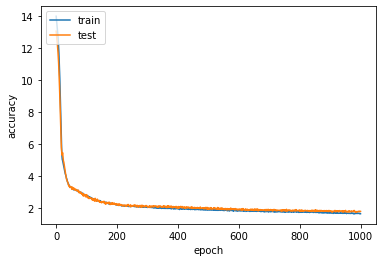

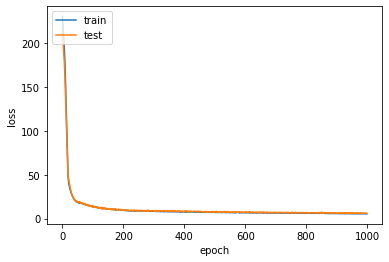

In [78]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mean_rmses, "../mean_rmse_dnn_loss_MC.dat")
save_obj(std_rmses, "../std_rmse_dnn_loss_MC.dat")


In [3]:
mc_pred=np.mean(pred,axis=0)
mc_pred

array([0.05279518, 0.03283933, 0.0537447 , 0.03974609, 0.03457924,
       0.03742982, 0.04465229, 0.05489689, 0.0322278 , 0.04860931,
       0.05708254, 0.04503478, 0.06214603, 0.04120987, 0.04285658,
       0.03374553, 0.04266082, 0.04460517, 0.04174339, 0.0369988 ,
       0.06102522, 0.04720526, 0.03547252, 0.04057915, 0.06028698,
       0.04594869, 0.03679036, 0.04504748, 0.05434823, 0.05183214,
       0.04711368, 0.03764421, 0.03771775, 0.05239221, 0.04771913,
       0.04199286, 0.05519148, 0.04541095, 0.06952468, 0.04033285,
       0.04858945, 0.03479638, 0.03056115, 0.03366404, 0.05692469,
       0.05566785, 0.0399124 , 0.04820377, 0.04281671, 0.03658003,
       0.05378899, 0.04206469, 0.04401018, 0.03655737, 0.06820614,
       0.05063169, 0.04610386, 0.05112227, 0.0458006 , 0.04457092,
       0.03266823, 0.04351811, 0.03674877, 0.03626641, 0.06036571,
       0.04281345, 0.04486926, 0.05853532, 0.0412476 , 0.03061781,
       0.03981644, 0.04545145, 0.04714443, 0.0347507 , 0.04353

In [4]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mc_pred, "../pred_loss_MC_Xx.dat")